In [184]:
import re
import math
import warnings
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
pio.renderers.default = "svg" # Save as static image => embed in jupyter notebook
warnings.filterwarnings('ignore') # ignore warning

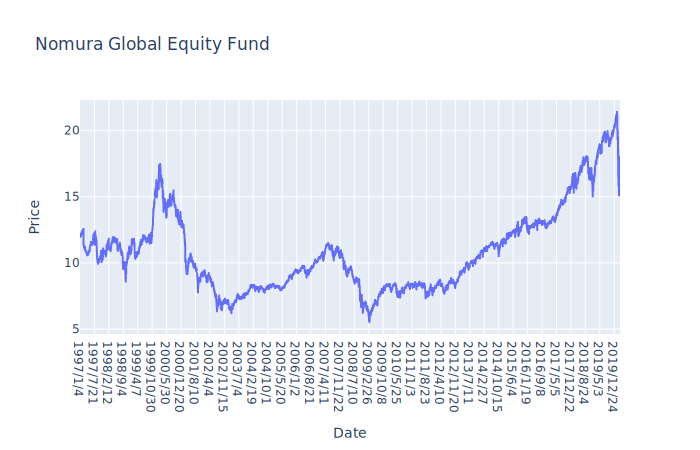

In [185]:
Data = pd.read_csv("Nomura_Global_Equity_Fund.csv")
fig = px.line(Data, x = "Date", y = "Price", title = 'Nomura Global Equity Fund')
fig.show()

In [ ]:
D_invest = investRoiDataFrame(investPriceAvg(percentDaysStrategDataFrame(10,10)))
dollarCostAveraging = investRoiDataFrame(investPriceAvg(percentDaysStrategDataFrame(100,30)))

fig = go.Figure()
fig.add_trace(go.Scatter(x=D_invest["Date"], y=D_invest["Price"], mode='lines', name='D-Invest'))
fig.add_trace(go.Scatter(x=dollarCostAveraging["Date"], y=dollarCostAveraging["Price"], mode='lines', name='DCA'))
fig.update_layout(title="Return on invest", xaxis_title="Date", yaxis_title="ROI")
fig.show()

In [4]:
yearStdBarChart(1997,2020)

In [179]:
def yearStdBarChart(start, end):
    '''Plot standard deviation bar chart between start year and end year'''
    monthStr = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    stdDataFrame = Data.groupby(["Year", "Month"]).std(ddof=0)
    fig = go.Figure()
    
    for i in range (end - start + 1):
        fig.add_trace(go.Bar(x = monthStr, y = stdDataFrame.loc[start + i]["Return(1)"].tolist(), name = str(start + i)))
    fig.update_layout(title="Year Standard Deviation", xaxis_title="Month", yaxis_title="Std")
    fig.show()

def percentDaysStrategDataFrame(percent, days):
    '''Return regular buying point and additional buying point'''
    regularDataFrame = Data.loc[Data["Day"] == 6] # Regular Buying
    additionalBuyingDataFrame = Data.loc[Data["Return(10)"] <= -percent / 100] # Additional Buying
    strategyDataFrame = pd.concat([regularDataFrame, additionalBuyingDataFrame], axis=0, ignore_index=True) # Concat
    strategyDataFrame = strategyDataFrame.sort_values(by=['Year', "Month"]).drop_duplicates(subset = "Date", keep = "last").reset_index(drop=True) # Sort, Delete repeated, Index
    
    return strategyDataFrame

def investPriceAvg(dataFrame):
    '''Return price average dataframe'''
    investPriceAvgDataFrame = pd.DataFrame(columns = ["Date", "Year", "Month", "Day", "Price"])
    priceAvg = 0
    for i in range(len(dataFrame["Price"])):
        priceAvg = (priceAvg * len(investPriceAvgDataFrame["Price"]) + dataFrame["Price"][i]) / (len(investPriceAvgDataFrame["Price"]) + 1)
        investPriceAvgDataFrame.loc[i] = [dataFrame["Date"][i], dataFrame["Year"][i], dataFrame["Month"][i], dataFrame["Day"][i], priceAvg]
    return investPriceAvgDataFrame.sort_values(by=['Year', "Month", "Day"]).reset_index(drop=True)

def investRoiDataFrame(dataFrame):
    '''Return roi dataframe'''
    roiDataFrame = pd.DataFrame(columns = ["Date", "Price"])
    j = 0
    priceAvg = math.inf
    
    for i in range (len(Data["Date"])):
        if (Data["Date"][i] < dataFrame["Date"][j]):
            roi = (Data["Price"][i] - priceAvg) / priceAvg
            
        elif (Data["Date"][i] == dataFrame["Date"][j]):
            priceAvg = dataFrame["Price"][j]
            roi = (Data["Price"][i] - priceAvg) / priceAvg
            if (j < len(dataFrame["Price"]) - 1):
                j += 1
            
        else:
            roi = (Data["Price"][i] - priceAvg) / dataFrame["Price"].tolist()[-1]
            
        roiDataFrame.loc[i] = [Data["Date"][i], roi]
    return roiDataFrame